# 0.0. IMPORTS

In [80]:
import pandas as pd
import inflection
import math 
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

## 0.1. Helper Functions

## 0.2. Loading data

In [3]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False)
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False)

In [4]:
#merge

df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

In [5]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1004970,26,5,2013-01-11,7223,603,1,1,0,0,d,a,2300.0,NaN,NaN,0,NaN,NaN,NaN


## 1.0. DESCRIÇÃO DOS DADOS

In [6]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [8]:
print ( 'Number of Rows: {}' .format(df1.shape[0] ) )
print ( 'Number of Cols: {}' .format(df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [9]:
df1['date'] = pd.to_datetime( df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

# 1.5. Fillout NA

In [11]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
316449,718,2,2014-10-07,9118,938,1,1,0,0,a,a,1100.0,6.0,2015.0,0,NaN,NaN,NaN


In [29]:
#competition_distance   
df1.competition_distance.fillna(200000., inplace=True)

#competition_open_since_month 
df1.competition_open_since_month.fillna(df1.date.dt.month, inplace=True)

#competition_open_since_year
df1.competition_open_since_year.fillna(df1.date.dt.year, inplace=True)

#promo2_since_week
df1.promo2_since_week.fillna(df1.date.dt.isocalendar().week, inplace=True)

#promo2_since_year
df1.promo2_since_year.fillna(df1.date.dt.year, inplace=True)

# substitui os 0 para '', assim não será necessário um dos if's do is_promo
df1['promo_interval'].replace(0, '', inplace=True)
# mesmo aqui
df1['promo_interval'].fillna('', inplace=True) 

# obtem a abreviatura do mês
df1['month_map'] = df1['date'].dt.strftime("%b") 

# como não tem 0's mais, tudo vai ser string, então podemos remover aqueles if's
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: x['month_map'] in x['promo_interval'].split( ',' ), axis='columns').astype('int')

# 1.6. Change Types

In [32]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [31]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )

df1['is_promo'] = df1['is_promo'].astype( 'int64' )


# 1.7. Descriptive Statistical

In [38]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])


# 1.7.1 Numerical Attributes

In [90]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame( num_attributes.apply( np.median )).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attribute', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m.head(5)

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723


## 1.7.2 Categorical Attributes

In [78]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

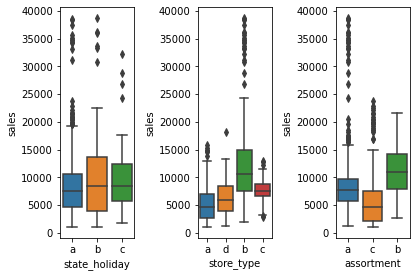

In [89]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0)] 

plt.subplot(1,3,1)
sns.boxplot( x='state_holiday', y='sales', data= aux1)

plt.subplot(1,3,2)
sns.boxplot( x='store_type', y='sales', data= aux1)

plt.subplot(1,3,3)
plt.tight_layout()
sns.boxplot( x='assortment', y='sales', data= aux1)